In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

## EDA

In [2]:
X_train = pd.read_csv('train.csv', header=None)
y_train = pd.read_csv('train-target.csv', header=None)
X_test = pd.read_csv('test.csv', header=None)
df_sub = pd.read_csv('sample-submission.csv', header=None)

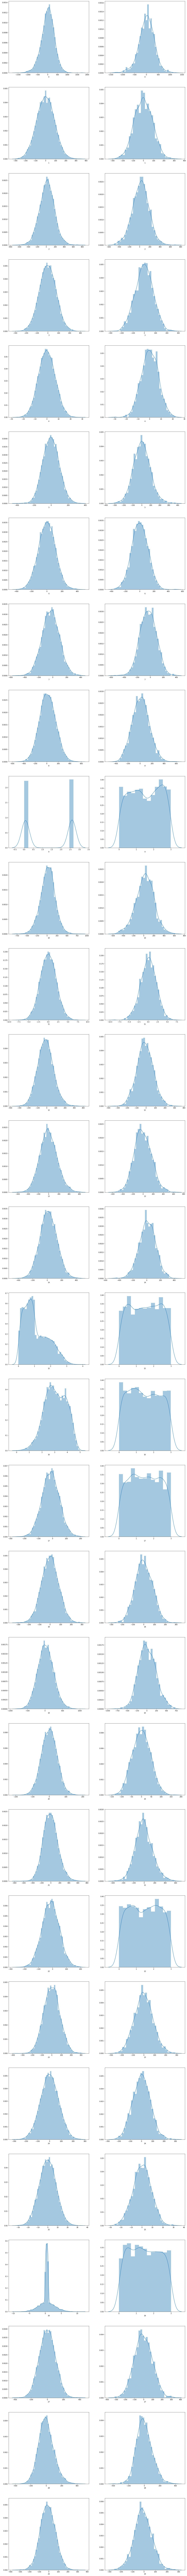

In [3]:
fig = plt.figure(figsize=(20, 300))
gs = fig.add_gridspec(30, 2)

for i in range(30):
    
    fig.add_subplot(gs[i, 0])
    sns.distplot(X_train[i])

    fig.add_subplot(gs[i, 1])
    sns.distplot(X_test[i])

plt.show()

## Валидация

In [4]:
# 1) напрямую выражают таргет
# 2) не совпадают распределения трейна и теста
# 3) диапазон значений сильно отличается от остальных фичей
# 4) ухудшают скор

drop_cols = [9, 15, 16, 22] + [17, 26] + [4, 11, 25] + [1, 3, 18, 20, 23, 27]

X_train_drop = X_train.drop(columns=drop_cols)

X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train_drop, 
    y_train, 
    test_size=0.3, 
    random_state=17
)

scaler = StandardScaler()
X_train_part_scaled = scaler.fit_transform(X_train_part)
X_train_part_scaled = pd.DataFrame(X_train_part_scaled, columns=X_train_part.columns, index=X_train_part.index)

X_valid_scaled = scaler.transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns, index=X_valid.index)

In [5]:
model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=100, C=1)

cv_scores = cross_val_score(
    model, 
    X_train_part_scaled, 
    y_train_part, 
    cv=StratifiedKFold(n_splits=5), 
    scoring='roc_auc', 
    n_jobs=-1
)

model.fit(X_train_part_scaled, y_train_part[0])

print('#', cv_scores)
print('#', cv_scores.mean(), cv_scores.std())

y_valid_pred = model.predict_proba(X_valid_scaled)[:, 1]

print('#', roc_auc_score(y_valid, y_valid_pred))

# [0.83975935 0.83009582 0.85305181 0.8063798  0.82876977]
# 0.8316113105539447 0.015317218038503238
# 0.8450711398160137


## Предсказание

In [6]:
X_train_drop = X_train.drop(columns=drop_cols)
X_test_drop = X_test.drop(columns=drop_cols)

In [7]:
scaler = StandardScaler()
scaler.fit(X_train_drop)

X_train_scaled = scaler.transform(X_train_drop)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_drop.columns, index=X_train_drop.index)

X_test_scaled = scaler.transform(X_test_drop)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_drop.columns, index=X_test_drop.index)

In [8]:
model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=100, C=1)

cv_scores = cross_val_score(
    model, 
    X_train_scaled, 
    y_train, 
    cv=StratifiedKFold(n_splits=5), 
    scoring='roc_auc', 
    n_jobs=-1
)

model.fit(X_train_scaled, y_train[0])

print('#', cv_scores)
print('#', cv_scores.mean(), cv_scores.std())

y_test = model.predict_proba(X_test_scaled)[:, 1]

# [0.84070573 0.83290129 0.8439914  0.83945195 0.83355736]
# 0.8381215431183586 0.004265818213740092


In [9]:
df_sub[0] = y_test

In [10]:
df_sub.to_csv('sub.csv', header=None, index=None)